In [128]:
import pandas as pd
import matplotlib.pyplot as plt
import math
import seaborn as sns
from scipy import stats
import numpy as np

from Bio import SeqUtils
from Bio.Seq import Seq
from Bio import motifs
import random
random.seed(2021)

In [129]:
utr_seq = pd.read_csv('../processed_data/yamanishi_data.csv')
utr_seq = utr_seq.loc[utr_seq.utr_seq.notna()]
utr_seq = utr_seq.loc[utr_seq.gene.notna()]
utr_seq

gene  intensity                                            utr_seq
0         AI1   0.405669  TTAATGATACTCAATATGGAAAGCCGTATGATGGGAAACTATCACG...
1         AI2   1.129300  TATTAAATATGCGTTAAATGGAGAGCCGTATGATATGAAAGTATCA...
2         AI3   0.760753  AATTATTATTACTTTCTTCCCCTCCGAATCCGTAATATATTTACGG...
3        TFC3   1.281130  ACATAATGAAATGAGGTGTATAAATTTTACTTTTATGTAACCAAAG...
4        VPS8   1.203350  TTTAATACAACTTTGGTTACATAAAAGTAAAATTTATACACCTCAT...
...       ...        ...                                                ...
5297  YPR196W   0.679095  CCCTAAATGAACTTTATCTTCTTACAGTTTCAACATCTTGTGACCT...
5298     SGE1   0.876187  CAATGAACAATTTTCCAACGTATAAATTAACTTATCGTAGTTCGAT...
5299     ARR1   0.731536  TATTCTTCCTGTAAGCACAGCGCAACATTGTCTTTCTTATTGTTAA...
5300     ARR2   1.088890  GCTCCTCAAGCTTTATTGTTCCAGCATTAATGTAAAAGTCTTTTCA...
5301     ARR3   0.250695  AATAGAAATTAATTGTTGACTCACCAAAAAATTACTTGGGCACCAA...

[5302 rows x 3 columns]

In [155]:
utr_seq['utr_seq'].apply(lambda x: len(x)).min()

400

In [130]:
utr_seq['log_intensity'] = utr_seq.intensity.apply(lambda x: np.log2(x))

<AxesSubplot:>

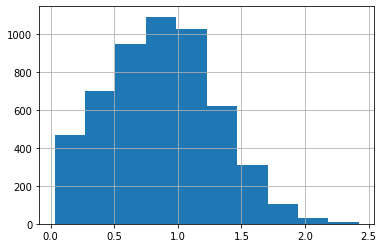

In [131]:
utr_seq.intensity.hist()

<AxesSubplot:>

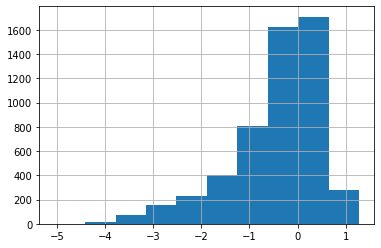

In [132]:
utr_seq.log_intensity.hist()

In [133]:
df = utr_seq
df = df.loc[df.intensity.notna()]
df.drop_duplicates(inplace = True)

<AxesSubplot:>

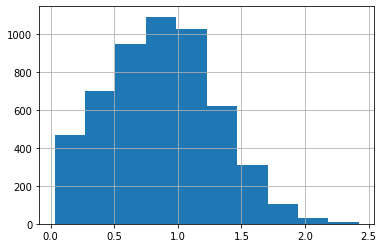

In [134]:
df.intensity.hist()

In [135]:
df['int_group'] = np.digitize(df['intensity'].values, df['intensity'].quantile(np.arange(0,1,0.1)).values) - 1
df['int_group'] = df.int_group.astype('category')

In [136]:
df.groupby('int_group').gene.count()

int_group
0    531
1    530
2    530
3    530
4    530
5    530
6    530
7    530
8    530
9    531
Name: gene, dtype: int64

### Sequence features extraction

In [154]:
df['len_seq'].min()

400

In [137]:
# Length of the sequence
df['len_seq'] = [len(i) for i in df.loc[:,'utr_seq']]
df['len_seq_log'] = [math.log2(len(i)) for i in df.loc[:,'utr_seq']]

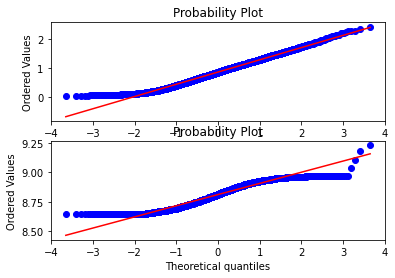

In [138]:
fig = plt.figure()
ax1 = fig.add_subplot(211)
prob = stats.probplot(df.intensity, dist=stats.norm, plot=ax1)

ax2 = fig.add_subplot(212)
prob = stats.probplot(df.len_seq_log, dist=stats.norm, plot=ax2)


In [139]:
# AT/GC ratio
df['at_gc'] = [(i.count('A')+i.count('T'))/(i.count('G')+i.count('C')) for i in df.loc[:,'utr_seq']]

In [140]:
# Percent GC
df['pct_gc'] = [SeqUtils.GC(i) for i in df.loc[:,'utr_seq']]

In [141]:
# Molecular weight
df['molecular_w'] = [SeqUtils.molecular_weight(i) for i in df.loc[:,'utr_seq']]

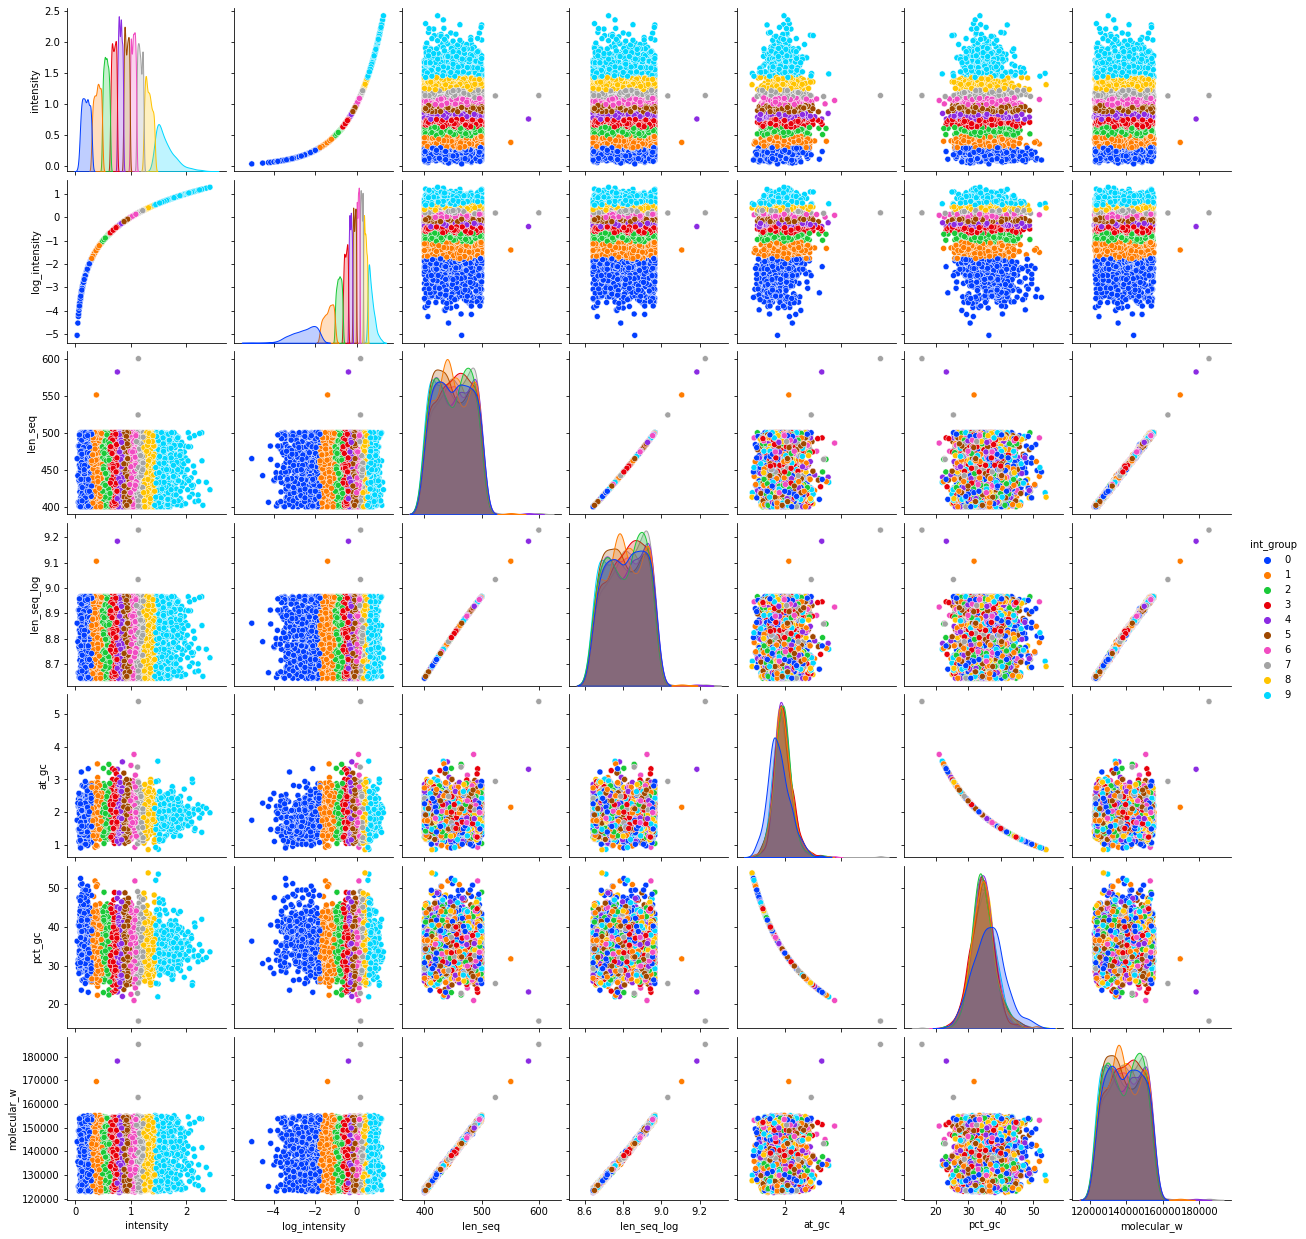

In [142]:
sns.pairplot(df, hue = 'int_group', palette = sns.color_palette('bright', 10))

In [144]:
corr = df.corr()
corr.style.background_gradient(cmap='coolwarm')

### Per group motif discovery (TBC)

[Gibbs Sampling](https://open.oregonstate.education/appliedbioinformatics/chapter/chapter-2-sequence-motifs/).

In [15]:
df.head()

gene systematicName  intensity  \
0   SSA1        YAL005C   2.477076   
1   ERP2        YAL007C  -1.204719   
2  FUN14        YAL008W  -0.785451   
3   SPO7        YAL009W  -3.608608   
4   SWC3        YAL011W  -3.443864   

                                             utr_seq int_group  len_seq  \
0  AGCCAATTGGTGCGGCAATTGATAATAACGAAAATGTCTTTTAATG...         9      147   
1  AGAACTTTTCAATCTACGAAAAATATATGTCCGCAATATAGAACAC...         8      286   
2  AGCAAGACAAATGACCAGATATAAACGAGGGTTATATTCTTTCGTT...         8      128   
3  AAAGAGTTGGAGGGCTTCTTCCTTCGAATAAGAGGTCATATTTACC...         3      134   
4  AGGTGTTCGGTTACTTTATTCTGCTTTAACGCCATTATGATTATAC...         3      135   

   len_seq_log     at_gc     pct_gc  molecular_w  
0     4.990433  2.585366  27.891156   45548.2183  
1     5.655992  2.445783  29.020979   88087.5535  
2     4.852030  2.459459  28.906250   39623.4302  
3     4.897840  2.268293  30.597015   41481.5762  
4     4.905275  2.375000  29.629630   41519.5406

In [16]:
import os
import csv
os.makedirs('meme_input', exist_ok=True)
def write_file(x):
    p = x['utr_seq'].apply(
        lambda y: f'>{id(y)}\n' + y)
    with open(f"meme_input/{x['int_group'].unique()[0]}_y.fasta", 'w') as out:
        out.write('\n'.join(p.values))
df.groupby('int_group').apply(write_file)

Empty DataFrame
Columns: []
Index: []

In [17]:
def write_inv_file(x, i):
    p = x['utr_seq'].apply(
        lambda y: f'>{id(y)}\n' + y)
    with open(f"meme_input/{i}inv_y.fasta", 'w') as out:
        out.write('\n'.join(p.values))
for cnt in range(10):
    write_inv_file(df[df['int_group'] != cnt], cnt)

In [19]:
from Bio.motifs import parse

In [24]:
motifs = []
motifs_s = {}
for cnt in range(10):
    with open(f"meme_output/{cnt}y.txt") as f:
        i_motifs = parse(f, 'MINIMAL')
        motifs_s[cnt] = [str(m.degenerate_consensus) for m in i_motifs]
        motifs.extend(i_motifs)

In [25]:
len(motifs)

36

In [26]:
motifs_s

{0: ['ATGCTTTTC',
  'AGTGGGG',
  'CGCGGAN',
  'SCTGCGCT',
  'CTCGATCACG',
  'CCGTTTACGAA'],
 1: ['AAAAAAAATTGTC', 'ATCTGCATTTTTCTT', 'AATAGGAAATA'],
 2: ['ATTATTTAC', 'ATGAACGGTT', 'ATTAAAATGC', 'AAAACGGTAGAC'],
 3: ['GAACCTGGGW', 'AACTTAATAAATAAA', 'TATTTACCAAA'],
 4: ['ACTTCTATTAA', 'AAATCGTCAT', 'AAATGATAAACTAKT'],
 5: ['AAAAATTCAKTCW', 'AGCGGTGACASCAG', 'ATGTCTTGCTA'],
 6: ['TSATATSA', 'CAAAATAAANAAWA', 'TATGTAATAGA'],
 7: ['TCAAACCCANW', 'ATATAGTTATTAAAT', 'CTTGTGTACTTATRT'],
 8: ['AGCWAGA', 'AAAGCGGAAACAAC', 'TATTACGCAAAYA', 'TAAAGGGCTA'],
 9: ['ATATACATATATATA', 'AATATCAATTATY', 'CCKTCTCTGA', 'CACTGAAAGT']}

In [27]:
seqs = [Seq(x) for x in df['utr_seq']]

In [28]:
from tqdm.notebook import tqdm

In [29]:
def create_features(seqs, motifs):
    scores = np.zeros([len(seqs), len(motifs)])
    counts = np.zeros([len(seqs), len(motifs)])
    for s_c, seq in tqdm(enumerate(seqs)):
        for m_c, motif in enumerate(motifs):
            try:
                weights = motif.pssm
                sc = weights.calculate(seq)
                counts[s_c, m_c] = sum(sc > 0)
                scores[s_c, m_c] = np.mean(sc[sc>0])
            except:
                counts[s_c, m_c] = 0
                scores[s_c, m_c] = None
    return counts, scores
    
            
counts, scores = create_features(seqs, motifs)

/home/vaslem/code/kaggle/.venv/lib/python3.8/site-packages/numpy/core/fromnumeric.py:3372: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/home/vaslem/code/kaggle/.venv/lib/python3.8/site-packages/numpy/core/_methods.py:170: RuntimeWarning: invalid value encountered in true_divide
  ret = ret.dtype.type(ret / rcount)


In [30]:
columns = [str(m.degenerate_consensus) for m in motifs]
columns_scores = [c + '_score' for c in columns]
columns_tfidf = [c + '_tfidf' for c in columns]

In [31]:
from sklearn.feature_extraction.text import TfidfTransformer
tfidf = TfidfTransformer().fit_transform(counts)
tfidf = tfidf.todense()

In [149]:
featDf = pd.DataFrame(np.hstack([scores, tfidf]), columns=columns_scores+columns_tfidf)

In [150]:
featDf.fillna(0, inplace=True)

In [151]:
featDf['intensity'] = df['log_intensity']
featDf['int_group'] = df['int_group']

Checking for significant difference in FI between genes with and without efficiency element.

In [153]:
p_vals = []
for e in columns_scores:
    grp0 = featDf.loc[featDf[e] == 0].intensity
    grp1 = featDf.loc[featDf[e] != 0].intensity
    f_val, p_val = stats.ttest_ind(grp0, grp1)            
    print(f"({e} size0 = {len(grp0)}, size1 = {len(grp1)}) One-way ANOVA P ={p_val}")
    p_vals.append(p_val)

(ATGCTTTTC_score size0 = 5238, size1 = 64) One-way ANOVA P =0.1305220305208135
(AGTGGGG_score size0 = 196, size1 = 5106) One-way ANOVA P =0.7909607578927652
(CGCGGAN_score size0 = 4474, size1 = 828) One-way ANOVA P =0.0012580866645419881
(SCTGCGCT_score size0 = 1275, size1 = 4027) One-way ANOVA P =0.6017792401361686
(CTCGATCACG_score size0 = 4938, size1 = 364) One-way ANOVA P =0.010149100791756417
(CCGTTTACGAA_score size0 = 2763, size1 = 2539) One-way ANOVA P =0.0020614588448428423
(AAAAAAAATTGTC_score size0 = 1166, size1 = 4136) One-way ANOVA P =0.03255428271712448
(ATCTGCATTTTTCTT_score size0 = 3460, size1 = 1842) One-way ANOVA P =0.6757537495453405
(AATAGGAAATA_score size0 = 5061, size1 = 241) One-way ANOVA P =0.979989679731546
(ATTATTTAC_score size0 = 1, size1 = 5301) One-way ANOVA P =nan
(ATGAACGGTT_score size0 = 20, size1 = 5282) One-way ANOVA P =0.22027425558416855
(ATTAAAATGC_score size0 = 4132, size1 = 1170) One-way ANOVA P =0.03740341113596783
(AAAACGGTAGAC_score size0 = 5187

/home/vaslem/code/kaggle/.venv/lib/python3.8/site-packages/numpy/core/fromnumeric.py:3621: RuntimeWarning:

Degrees of freedom <= 0 for slice

/home/vaslem/code/kaggle/.venv/lib/python3.8/site-packages/numpy/core/_methods.py:226: RuntimeWarning:

invalid value encountered in double_scalars



In [36]:
from statsmodels.stats.multitest import fdrcorrection
q_vals = fdrcorrection(p_vals)[1]

In [37]:
sig_mots = np.array(columns_scores)[q_vals < 0.05]

In [38]:
len(sig_mots)

0

In [39]:
df['int_group'] = df['int_group'].astype(float)

In [41]:
# sns.pairplot(df[sig_mots.tolist() + ['int_group']], hue = 'int_group', palette = sns.color_palette('bright', 10))

In [42]:
df

ATGCTTTTC_score  AGTGGGG_score  CGCGGAN_score  SCTGCGCT_score  \
0                 0.0       2.642990       0.000000        5.755253   
1                 0.0       2.794628       0.000000        4.976997   
2                 0.0       3.471405      12.496031        2.535463   
3                 0.0       2.166615       0.000000        5.302664   
4                 0.0       4.001960       0.000000        1.808053   
...               ...            ...            ...             ...   
5297              0.0       3.669986       0.000000        3.667003   
5298              0.0       3.516900       0.000000        0.749351   
5299              0.0       2.562914       0.000000        5.058574   
5300              0.0       0.797256       0.000000        0.000000   
5301              0.0       2.357609       0.000000        0.000000   

      CTCGATCACG_score  CCGTTTACGAA_score  AAAAAAAATTGTC_score  \
0             0.000000           2.653590             0.000000   
1             0.000000           3.036529             3.408208   
2             0.000000           5.208936             4.780993   
3             0.000000           2.950496             0.000000   
4             2.791845           0.758040             2.273583   
...                ...                ...                  ...   
5297          0.000000           0.000000             1.549973   
5298          0.000000           0.000000             2.708370   
5299          0.000000           0.000000             1.737464   
5300          0.000000           0.000000             4.672851   
5301          0.000000           1.638258            11.553675   

      ATCTGCATTTTTCTT_score  AATAGGAAATA_score  ATTATTTAC_score  ...  \
0                  0.000000            0.00000         1.372398  ...   
1                  0.446592            0.00000         2.323339  ...   
2                  0.000000            0.00000         3.212597  ...   
3                  0.000000            0.00000         1.762685  ...   
4                  0.000000            0.00000         2.398481  ...   
...                     ...                ...              ...  ...   
5297               1.329976            0.00000         1.636708  ...   
5298               4.978054            0.00000         3.046859  ...   
5299               0.000000            5.13286         2.052178  ...   
5300               0.000000            0.00000         1.207183  ...   
5301               2.282836            0.00000         1.168469  ...   

      AGCWAGA_tfidif  AAAGCGGAAACAAC_tfidif  TATTACGCAAAYA_tfidif  \
0           0.000000               0.000000                   0.0   
1           0.000000               0.000000                   0.0   
2           0.000000               0.000000                   0.0   
3           0.198485               0.000000                   0.0   
4           0.000000               0.000000                   0.0   
...              ...                    ...                   ...   
5297        0.000000               0.000000                   0.0   
5298        0.000000               0.000000                   0.0   
5299        0.000000               0.000000                   0.0   
5300        0.000000               0.000000                   0.0   
5301        0.000000               0.142864                   0.0   

      TAAAGGGCTA_tfidif  ATATACATATATATA_tfidif  AATATCAATTATY_tfidif  \
0              0.000000                     0.0                   0.0   
1              0.097272                     0.0                   0.0   
2              0.000000                     0.0                   0.0   
3              0.000000                     0.0                   0.0   
4              0.000000                     0.0                   0.0   
...                 ...                     ...                   ...   
5297           0.000000                     0.0                   0.0   
5298           0.000000                     0.0                   0.0   
5299     

### PCA

In [43]:
import plotly
from plotly import version
print (version)
from plotly.offline import download_plotlyjs, init_notebook_mode, plot, iplot
init_notebook_mode(connected=True)

<module 'plotly.version' from '/home/vaslem/code/kaggle/.venv/lib/python3.8/site-packages/plotly/version.py'>


In [44]:
from sklearn.decomposition import PCA
import plotly.express as px

In [72]:
features = columns_tfidf + columns_scores

In [73]:
df_temp = df[features]
# df_temp = df_6mers_test.loc[:, (df_6mers.columns != 'gene') & (df_6mers.columns != 'intensity')]
# df_temp = (df_temp-df_temp.mean())/df_temp.std()
# df_temp = (df_temp-df_temp.min())/(df_temp.max()-df_temp.min())
df_temp

ATGCTTTTC_tfidif  AGTGGGG_tfidif  CGCGGAN_tfidif  SCTGCGCT_tfidif  \
0                  0.0        0.530767         0.00000         0.217389   
1                  0.0        0.369128         0.00000         0.045356   
2                  0.0        0.743501         0.12789         0.114195   
3                  0.0        0.602017         0.00000         0.147943   
4                  0.0        0.331861         0.00000         0.081553   
...                ...             ...             ...              ...   
5297               0.0        0.129357         0.00000         0.158945   
5298               0.0        0.201706         0.00000         0.082614   
5299               0.0        0.454221         0.00000         0.159461   
5300               0.0        0.573013         0.00000         0.000000   
5301               0.0        0.511712         0.00000         0.000000   

      CTCGATCACG_tfidif  CCGTTTACGAA_tfidif  AAAAAAAATTGTC_tfidif  \
0              0.000000            0.148004              0.000000   
1              0.000000            0.061759              0.399654   
2              0.000000            0.155494              0.111804   
3              0.000000            0.302170              0.000000   
4              0.235138            0.111047              0.239537   
...                 ...                 ...                   ...   
5297           0.000000            0.000000              0.077808   
5298           0.000000            0.000000              0.323536   
5299           0.000000            0.000000              0.078061   
5300           0.000000            0.000000              0.076593   
5301           0.000000            0.214036              0.076948   

      ATCTGCATTTTTCTT_tfidif  AATAGGAAATA_tfidif  ATTATTTAC_tfidif  ...  \
0                   0.000000            0.000000          0.554233  ...   
1                   0.073170            0.000000          0.604857  ...   
2                   0.000000            0.000000          0.403116  ...   
3                   0.000000            0.000000          0.290138  ...   
4                   0.000000            0.000000          0.575779  ...   
...                      ...                 ...               ...  ...   
5297                0.128208            0.000000          0.561086  ...   
5298                0.133276            0.000000          0.518459  ...   
5299                0.000000            0.255581          0.625455  ...   
5300                0.000000            0.000000          0.429583  ...   
5301                0.126791            0.000000          0.616541  ...   

      ATATAGTTATTAAAT_score  CTTGTGTACTTATRT_score  AGCWAGA_score  \
0                       0.0               0.000000       0.000000   
1                       0.0               7.734814       0.000000   
2                       0.0               0.000000       0.000000   
3                       0.0               0.000000      12.241595   
4                       0.0               0.000000       0.000000   
...                     ...                    ...            ...   
5297                    0.0               0.000000       0.000000   
5298                    0.0               0.000000       0.000000   
5299                    0.0               3.481800       0.000000   
5300                    0.0               0.000000       0.000000   
5301                    0.0               0.000000       0.000000   

      AAAGCGGAAACAAC_score  TATTACGCAAAYA_score  TAAAGGGCTA_score  \
0                  0.00000                  0.0          0.000000   
1                  0.00000                  0.0          0.626624   
2                  0.00000                  0.0          0.000000   
3                  0.00000                  0.0          0.000000   
4                  0.00000                  0.0          0.000000   
...                    ...                  ...               ...   
5297               0.00000                  0.0          0.0000

In [74]:
%matplotlib inline

In [75]:
pca = PCA(n_components = 7)
components = pca.fit_transform(df_temp)
labels = {
    str(i): f"PC {i+1} ({var:.1f}%)"
    for i, var in enumerate(pca.explained_variance_ratio_ * 100)
}

total_var = pca.explained_variance_ratio_.sum() * 100

fig = px.scatter_matrix(
    components,
    labels=labels,
    dimensions=range(7),
    color=df.int_group,
    title=f'Total Explained Variance: {total_var:.2f}%',
)
fig.update_traces(diagonal_visible=False)
fig.show()

In [76]:
loadings = pca.components_.T * np.sqrt(pca.explained_variance_)

x = 0
y = 1

fig = px.scatter(components, x=x, y=y, color=df.int_group)

for i, feature in enumerate(features):
    fig.add_shape(
        type='line',
        x0=0, y0=0,
        x1=loadings[i, x],
        y1=loadings[i, y]
    )
    fig.add_annotation(
        x=loadings[i, x],
        y=loadings[i, y],
        ax=0, ay=0,
        xanchor="center",
        yanchor="bottom",
        text=feature,
    )
fig.show()

In [50]:
exp_var_cumul = np.cumsum(pca.explained_variance_ratio_)

px.area(
    x=range(1, exp_var_cumul.shape[0] + 1),
    y=exp_var_cumul,
    labels={"x": "# Components", "y": "Explained Variance"}
)

### Classification (RF)

[Source](https://www.blopig.com/blog/2017/07/using-random-forests-in-python-with-scikit-learn/)

In [51]:

# df_temp = pd.DataFrame(components)
df_temp = df.loc[:, features]

# df_temp = (df_temp-df_temp.mean())/df_temp.std()
df_temp

ATGCTTTTC_tfidif  AGTGGGG_tfidif  CGCGGAN_tfidif  SCTGCGCT_tfidif  \
0                  0.0        0.530767         0.00000         0.217389   
1                  0.0        0.369128         0.00000         0.045356   
2                  0.0        0.743501         0.12789         0.114195   
3                  0.0        0.602017         0.00000         0.147943   
4                  0.0        0.331861         0.00000         0.081553   
...                ...             ...             ...              ...   
5297               0.0        0.129357         0.00000         0.158945   
5298               0.0        0.201706         0.00000         0.082614   
5299               0.0        0.454221         0.00000         0.159461   
5300               0.0        0.573013         0.00000         0.000000   
5301               0.0        0.511712         0.00000         0.000000   

      CTCGATCACG_tfidif  CCGTTTACGAA_tfidif  AAAAAAAATTGTC_tfidif  \
0              0.000000            0.148004              0.000000   
1              0.000000            0.061759              0.399654   
2              0.000000            0.155494              0.111804   
3              0.000000            0.302170              0.000000   
4              0.235138            0.111047              0.239537   
...                 ...                 ...                   ...   
5297           0.000000            0.000000              0.077808   
5298           0.000000            0.000000              0.323536   
5299           0.000000            0.000000              0.078061   
5300           0.000000            0.000000              0.076593   
5301           0.000000            0.214036              0.076948   

      ATCTGCATTTTTCTT_tfidif  AATAGGAAATA_tfidif  ATTATTTAC_tfidif  ...  \
0                   0.000000            0.000000          0.554233  ...   
1                   0.073170            0.000000          0.604857  ...   
2                   0.000000            0.000000          0.403116  ...   
3                   0.000000            0.000000          0.290138  ...   
4                   0.000000            0.000000          0.575779  ...   
...                      ...                 ...               ...  ...   
5297                0.128208            0.000000          0.561086  ...   
5298                0.133276            0.000000          0.518459  ...   
5299                0.000000            0.255581          0.625455  ...   
5300                0.000000            0.000000          0.429583  ...   
5301                0.126791            0.000000          0.616541  ...   

      ATATAGTTATTAAAT_tfidif  CTTGTGTACTTATRT_tfidif  AGCWAGA_tfidif  \
0                        0.0                0.000000        0.000000   
1                        0.0                0.120006        0.000000   
2                        0.0                0.000000        0.000000   
3                        0.0                0.000000        0.198485   
4                        0.0                0.000000        0.000000   
...                      ...                     ...             ...   
5297                     0.0                0.000000        0.000000   
5298                     0.0                0.000000        0.000000   
5299                     0.0                0.210957        0.000000   
5300                     0.0                0.000000        0.000000   
5301                     0.0                0.000000        0.000000   

      AAAGCGGAAACAAC_tfidif  TATTACGCAAAYA_tfidif  TAAAGGGCTA_tfidif  \
0                  0.000000                   0.0           0.000000   
1                  0.000000                   0.0           0.097272   
2                  0.000000                   0.0           0.000000   
3                  0.000000                   0.0           0.000000   
4                  0.000000                   0.0           0.000000   
...                     ...                   ...                ...   
5297  

In [79]:
from sklearn.model_selection import train_test_split
df_subset = df[df['int_group'].isin([0,9])]
df_subset['int_bool'] = df_subset.int_group.astype(float) >= 5
X_train, X_test, y_train, y_test = train_test_split(df_subset.loc[:,features], df_subset.int_bool, test_size=0.5,
                                                    stratify=df_subset.int_bool, random_state=123456)

<ipython-input-79-5b2ddcdb4b36>:3: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



In [80]:
X_train

ATGCTTTTC_tfidif  AGTGGGG_tfidif  CGCGGAN_tfidif  SCTGCGCT_tfidif  \
1037          0.000000        0.256490        0.000000         0.189094   
4332          0.000000        0.639366        0.000000         0.471364   
2543          0.000000        0.290778        0.160054         0.214372   
201           0.000000        0.199889        0.000000         0.122804   
5238          0.000000        0.450866        0.155107         0.069249   
...                ...             ...             ...              ...   
2414          0.000000        0.411494        0.000000         0.288922   
1717          0.297927        0.515088        0.000000         0.140645   
4547          0.000000        0.461978        0.000000         0.000000   
615           0.000000        0.332969        0.000000         0.204564   
1776          0.000000        0.481009        0.189116         0.084433   

      CTCGATCACG_tfidif  CCGTTTACGAA_tfidif  AAAAAAAATTGTC_tfidif  \
1037                0.0            0.000000              0.185134   
4332                0.0            0.213944              0.230746   
2543                0.0            0.000000              0.139922   
201                 0.0            0.167217              0.240465   
5238                0.0            0.094293              0.135598   
...                 ...                 ...                   ...   
2414                0.0            0.295058              0.070718   
1717                0.0            0.095755              0.000000   
4547                0.0            0.000000              0.069470   
615                 0.0            0.139272              0.200280   
1776                0.0            0.229936              0.165329   

      ATCTGCATTTTTCTT_tfidif  AATAGGAAATA_tfidif  ATTATTTAC_tfidif  ...  \
1037                0.000000                 0.0          0.593345  ...   
4332                0.000000                 0.0          0.308139  ...   
2543                0.000000                 0.0          0.504500  ...   
201                 0.000000                 0.0          0.481675  ...   
5238                0.223430                 0.0          0.488908  ...   
...                      ...                 ...               ...  ...   
2414                0.116525                 0.0          0.566620  ...   
1717                0.000000                 0.0          0.551652  ...   
4547                0.343404                 0.0          0.389633  ...   
615                 0.165005                 0.0          0.481417  ...   
1776                0.000000                 0.0          0.529873  ...   

      ATATAGTTATTAAAT_score  CTTGTGTACTTATRT_score  AGCWAGA_score  \
1037                    0.0               0.000000            0.0   
4332                    0.0               0.000000            0.0   
2543                    0.0               6.861417            0.0   
201                     0.0               0.000000            0.0   
5238                    0.0               0.000000            0.0   
...                     ...                    ...            ...   
2414                    0.0               0.000000            0.0   
1717                    0.0               0.000000            0.0   
4547                    0.0               0.000000            0.0   
615                     0.0               0.000000            0.0   
1776                    0.0               0.000000            0.0   

      AAAGCGGAAACAAC_score  TATTACGCAAAYA_score  TAAAGGGCTA_score  \
1037              0.000000                  0.0          0.000000   
4332              0.000000                  0.0          0.000000   
2543              4.645365                  0.0          0.000000   
201               0.000000                  0.0          0.000000   
5238              0.000000                  0.0          0.000000   
...                    ...                  ...               ...   
2414              3.964918                  0.0          0.0000

In [81]:
y_train

1037     True
4332    False
2543     True
201      True
5238     True
        ...  
2414    False
1717    False
4547     True
615      True
1776    False
Name: int_bool, Length: 531, dtype: bool

Mean accuracy score: 0.723


[Text(418.5, 733.86, 'TATTTACCAAA_tfidif <= 0.085\ngini = 0.5\nsamples = 531\nvalue = [266, 265]'),
 Text(209.25, 570.78, 'ATTATTTAC_tfidif <= 0.438\ngini = 0.486\nsamples = 309\nvalue = [180, 129]'),
 Text(104.625, 407.70000000000005, 'ATGAACGGTT_score <= 2.267\ngini = 0.413\nsamples = 134\nvalue = [95, 39]'),
 Text(52.3125, 244.62, 'SCTGCGCT_score <= 0.054\ngini = 0.479\nsamples = 73\nvalue = [44, 29]'),
 Text(26.15625, 81.54000000000008, 'gini = 0.355\nsamples = 13\nvalue = [3, 10]'),
 Text(78.46875, 81.54000000000008, 'gini = 0.433\nsamples = 60\nvalue = [41, 19]'),
 Text(156.9375, 244.62, 'AAATGATAAACTAKT_tfidif <= 0.226\ngini = 0.274\nsamples = 61\nvalue = [51, 10]'),
 Text(130.78125, 81.54000000000008, 'gini = 0.212\nsamples = 58\nvalue = [51, 7]'),
 Text(183.09375, 81.54000000000008, 'gini = 0.0\nsamples = 3\nvalue = [0, 3]'),
 Text(313.875, 407.70000000000005, 'CACTGAAAGT_score <= 1.261\ngini = 0.5\nsamples = 175\nvalue = [85, 90]'),
 Text(261.5625, 244.62, 'ATTAAAATGC_score <

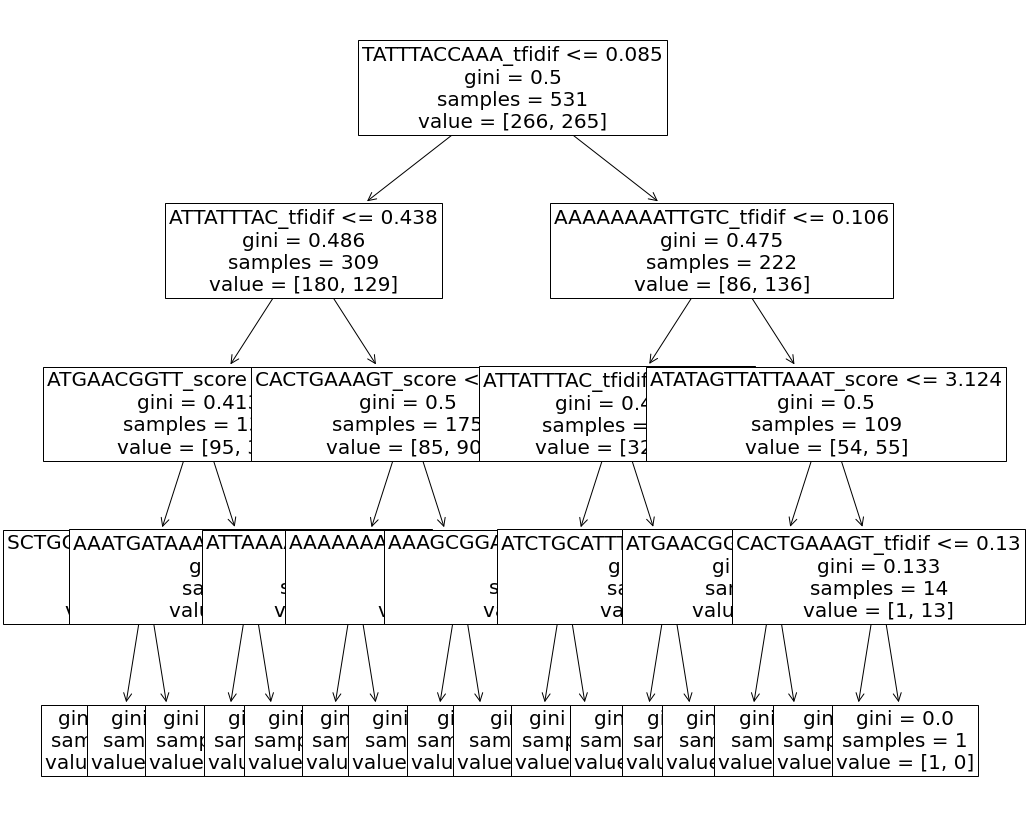

In [102]:

from sklearn.tree import DecisionTreeClassifier
t = DecisionTreeClassifier(random_state=123456, max_depth=4)
t.fit(X_train, y_train)
from sklearn.metrics import accuracy_score
predicted = t.predict(X_train)
accuracy = accuracy_score(y_train, predicted)
print(f'Mean accuracy score: {accuracy:.3}')
from sklearn.tree import plot_tree
fig,ax=plt.subplots(1,1, figsize=(15,15))
plot_tree(t,feature_names=features,ax=ax,fontsize=20)

In [90]:
from sklearn.ensemble import RandomForestClassifier
rf = RandomForestClassifier(n_estimators=100, oob_score=True, random_state=123456, max_depth=3)
rf.fit(X_train, y_train)

/home/vaslem/code/kaggle/.venv/lib/python3.8/site-packages/sklearn/base.py:445: UserWarning:

X does not have valid feature names, but RandomForestClassifier was fitted with feature names



RandomForestClassifier(max_depth=3, oob_score=True, random_state=123456)

In [91]:
from sklearn.metrics import accuracy_score
predicted = rf.predict(X_train)
accuracy = accuracy_score(y_train, predicted)
print(f'Out-of-bag score estimate: {rf.oob_score_:.3}')
print(f'Mean accuracy score: {accuracy:.3}')

Out-of-bag score estimate: 0.586
Mean accuracy score: 0.761


In [ ]:
rf.

In [56]:
from sklearn.metrics import accuracy_score
predicted = rf.predict(X_test)
accuracy = accuracy_score(y_test, predicted)
print(f'Out-of-bag score estimate: {rf.oob_score_:.3}')
print(f'Mean accuracy score: {accuracy:.3}')

Out-of-bag score estimate: 0.597
Mean accuracy score: 0.589


<AxesSubplot:>

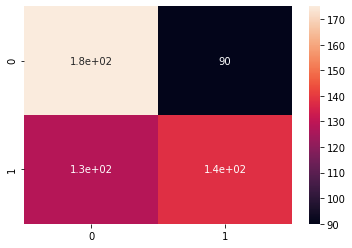

In [57]:
from sklearn.metrics import confusion_matrix
cm = pd.DataFrame(confusion_matrix(y_test, predicted), columns=range(2), index=range(2))
sns.heatmap(cm, annot=True)

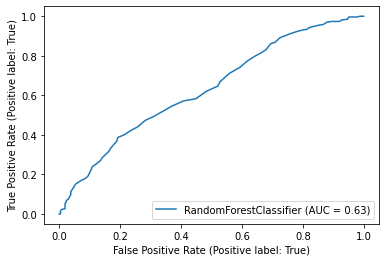

In [58]:
from sklearn.metrics import RocCurveDisplay
rf_disp = RocCurveDisplay.from_estimator(rf, X_test, y_test)
plt.show()

### Regression (RF)

[Source](https://www.blopig.com/blog/2017/07/using-random-forests-in-python-with-scikit-learn/)

In [112]:
from sklearn.preprocessing import StandardScaler

X_train, X_test, y_train, y_test = train_test_split(df_subset.loc[:,features], df_subset.int_group, train_size=0.8, random_state=42)
scaler = StandardScaler().fit(X_train)
X_train_scaled = pd.DataFrame(scaler.transform(X_train), index=X_train.index.values, columns=X_train.columns.values)
X_test_scaled = pd.DataFrame(scaler.transform(X_test), index=X_test.index.values, columns=X_test.columns.values)

In [113]:
from sklearn.metrics import mean_squared_error as mse

In [114]:
np.sqrt(np.sum((y_train - np.mean(y_train))**2)/len(y_train))

4.498872987515812

Mean squared score: 14.1


[Text(820.2599999999999, 1494.8999999999999, 'TATTTACCAAA_tfidif <= 0.085\nsquared_error = 20.24\nsamples = 849\nvalue = 4.601'),
 Text(351.53999999999996, 1223.1, 'ATTATTTAC_tfidif <= 0.436\nsquared_error = 19.592\nsamples = 488\nvalue = 3.689'),
 Text(167.39999999999998, 951.3, 'ATATACATATATATA_tfidif <= 0.162\nsquared_error = 17.095\nsamples = 228\nvalue = 2.724'),
 Text(133.92, 679.4999999999999, 'ATGAACGGTT_score <= 2.249\nsquared_error = 16.349\nsamples = 221\nvalue = 2.525'),
 Text(66.96, 407.6999999999998, 'ATTATTTAC_tfidif <= 0.365\nsquared_error = 19.529\nsamples = 106\nvalue = 3.651'),
 Text(33.48, 135.89999999999986, 'squared_error = 16.922\nsamples = 74\nvalue = 2.676'),
 Text(100.44, 135.89999999999986, 'squared_error = 18.272\nsamples = 32\nvalue = 5.906'),
 Text(200.88, 407.6999999999998, 'ATATAGTTATTAAAT_score <= 7.419\nsquared_error = 11.172\nsamples = 115\nvalue = 1.487'),
 Text(167.39999999999998, 135.89999999999986, 'squared_error = 10.068\nsamples = 110\nvalue = 1

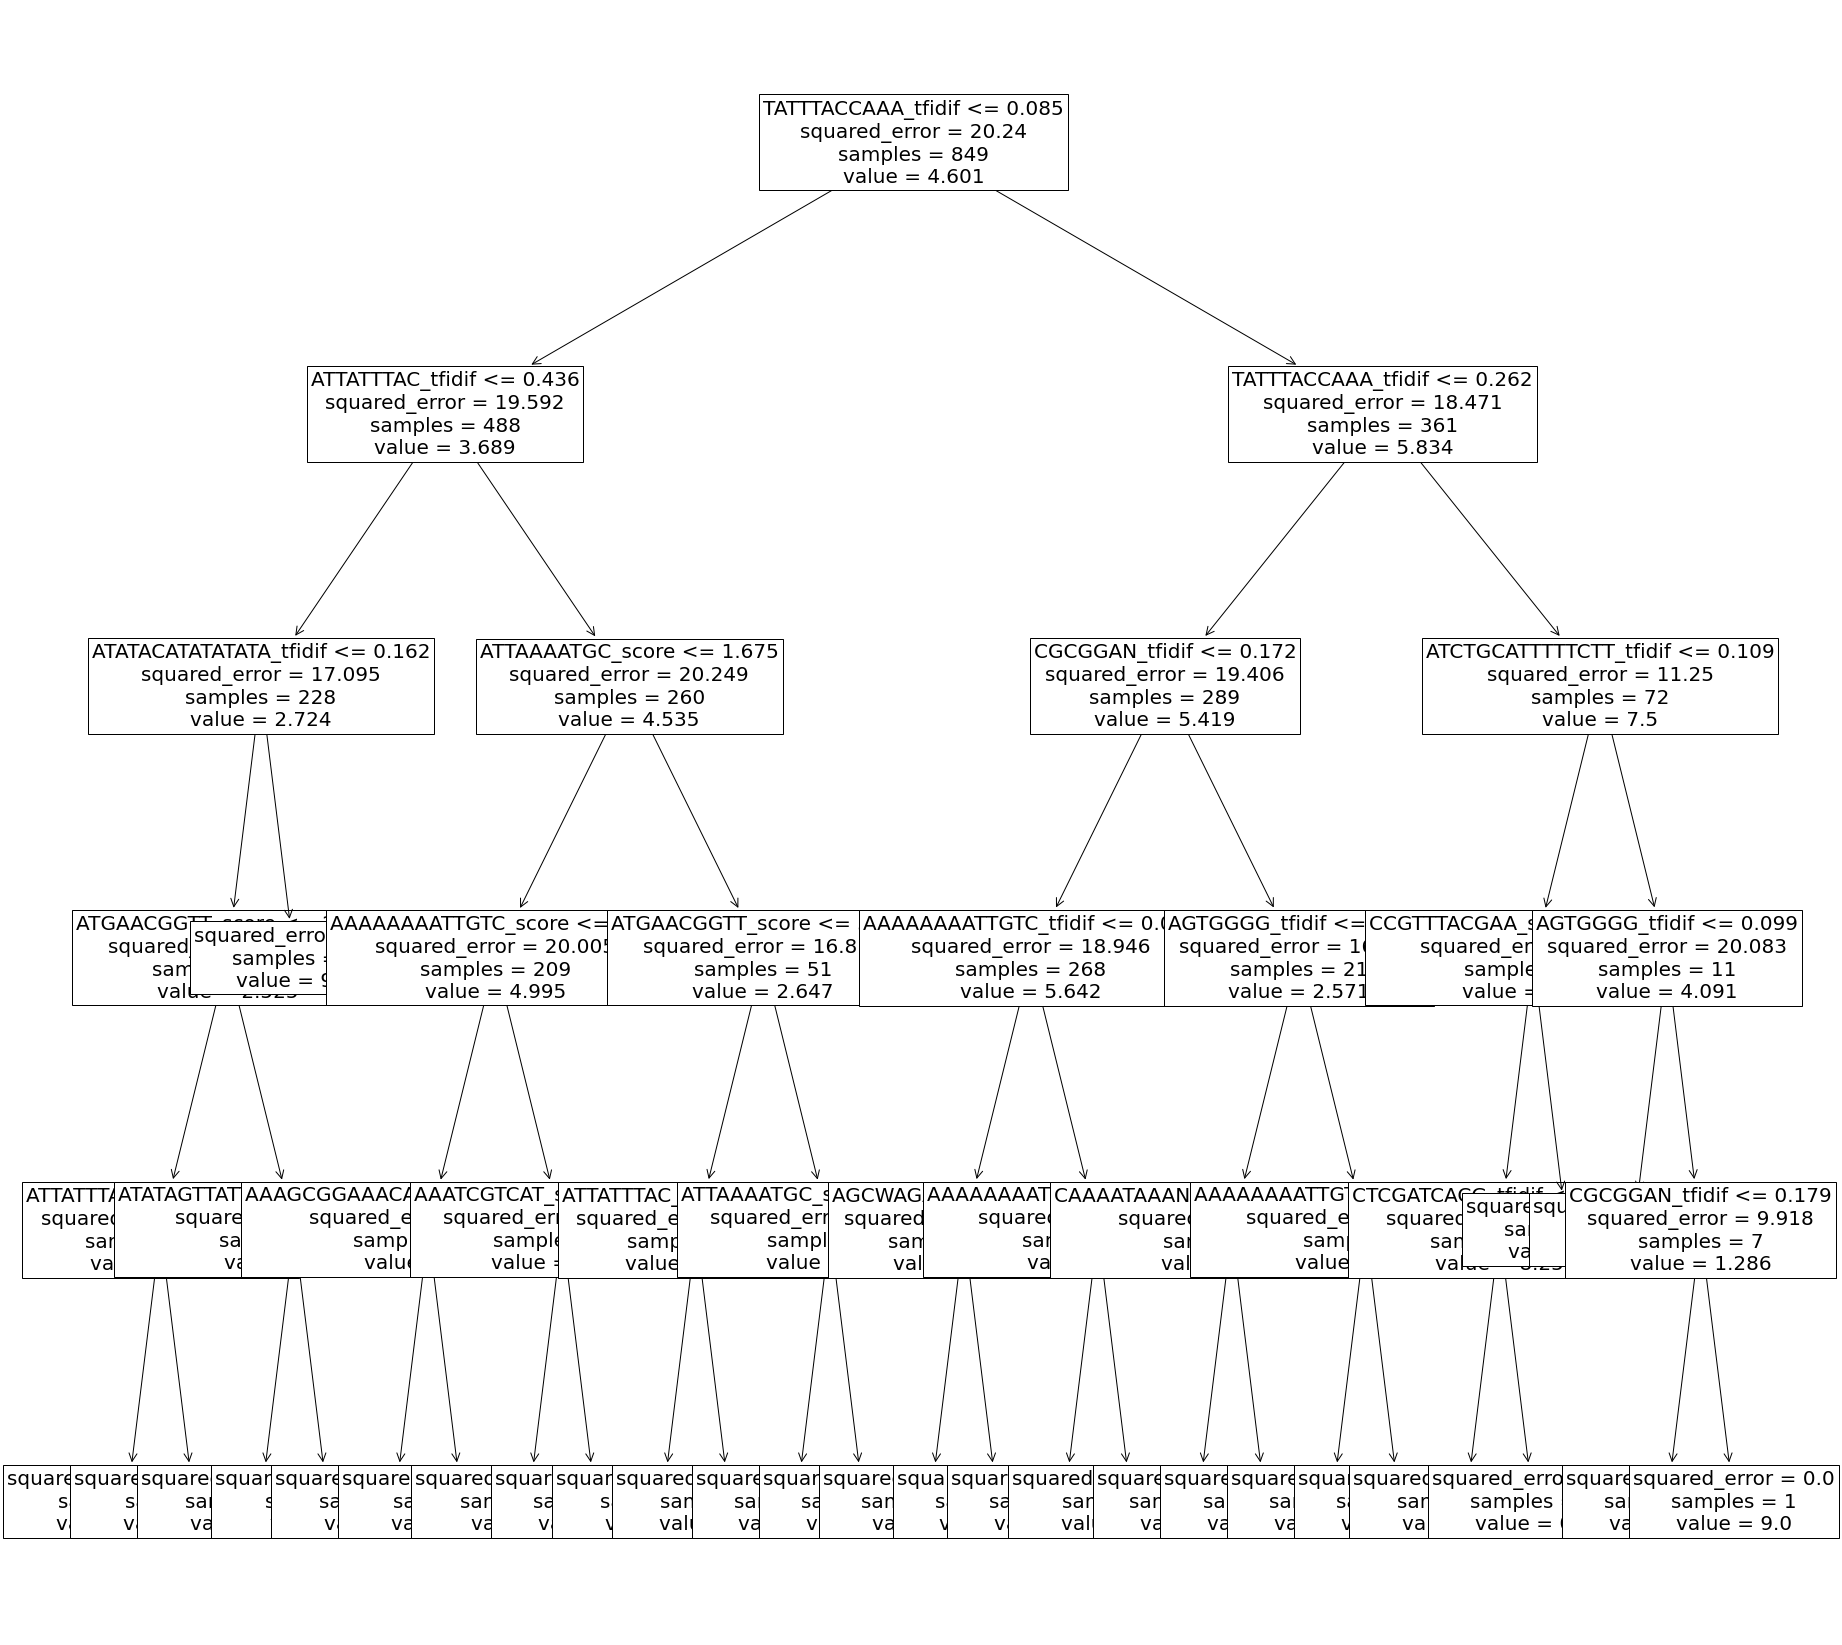

In [115]:
from sklearn.tree import DecisionTreeRegressor
t = DecisionTreeRegressor(random_state=123456, max_depth=5)
t.fit(X_train, y_train)
from sklearn.metrics import accuracy_score
predicted = t.predict(X_train)
m = mse(y_train, predicted)
print(f'Mean squared score: {m:.3}')
from sklearn.tree import plot_tree
fig,ax=plt.subplots(1,1, figsize=(30,30))
plot_tree(t,feature_names=features,ax=ax,fontsize=20)

In [61]:
from sklearn.ensemble import RandomForestRegressor
rf = RandomForestRegressor(n_estimators=500, oob_score=True, random_state=0, n_jobs=-1)
rf.fit(X_train, y_train)

/home/vaslem/code/kaggle/.venv/lib/python3.8/site-packages/sklearn/base.py:445: UserWarning:

X does not have valid feature names, but RandomForestRegressor was fitted with feature names



RandomForestRegressor(n_estimators=500, n_jobs=-1, oob_score=True,
                      random_state=0)

In [62]:
from sklearn.metrics import r2_score
from scipy.stats import spearmanr, pearsonr
predicted_train = rf.predict(X_train)
predicted_test = rf.predict(X_test)
test_score = r2_score(y_test, predicted_test)
spearman = spearmanr(y_test, predicted_test)
pearson = pearsonr(y_test, predicted_test)
print(f'Out-of-bag R-2 score estimate: {rf.oob_score_:>5.3}')
print(f'Test data R-2 score: {test_score:>5.3}')
print(f'Test data Spearman correlation: {spearman[0]:.3}')
print(f'Test data Pearson correlation: {pearson[0]:.3}')

Out-of-bag R-2 score estimate: 0.0603
Test data R-2 score: 0.027
Test data Spearman correlation: 0.271
Test data Pearson correlation: 0.234


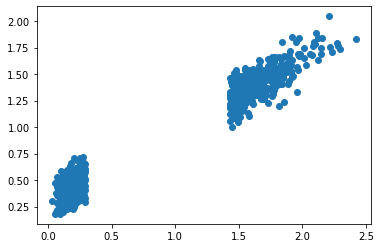

In [63]:
plt.scatter(y_train, predicted_train)

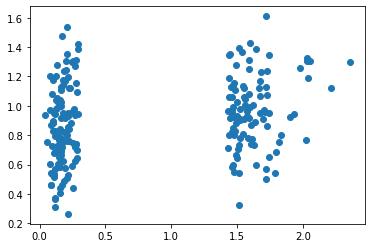

In [64]:
plt.scatter(y_test, predicted_test)

In [65]:
from umap.umap_ import UMAP

In [66]:
umap = UMAP().fit(df_temp[features])

In [69]:
import umap.plot  # pip install umap-learn[plot]

umap.plot.points(umap, labels=df['intensity'], theme="viridis")

ValueError: Could not find embedding attribute of umap_object

<AxesSubplot:>

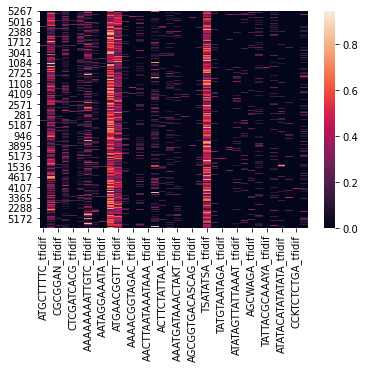

In [70]:
sns.heatmap(df.sort_values('intensity')[features])

<AxesSubplot:>

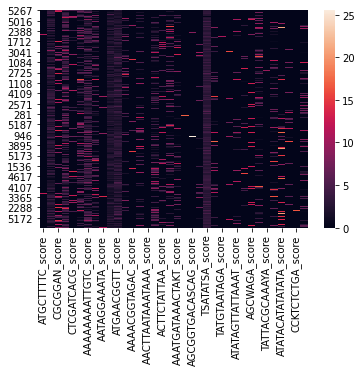

In [71]:
sns.heatmap(df.sort_values('intensity')[columns_scores])